<a href="https://colab.research.google.com/github/jan-de-trop/Post-hurricane-damage-assessment/blob/main/Post_Hurricane_damage_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying buildings Post Hurricane using Satellite Imagery



## Introduction

## Problem Statement

The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we ask you to classify buildings between damaged and not damaged buildings using the satellite imagery data provided to you. 

## Approach to Solve the Problem 

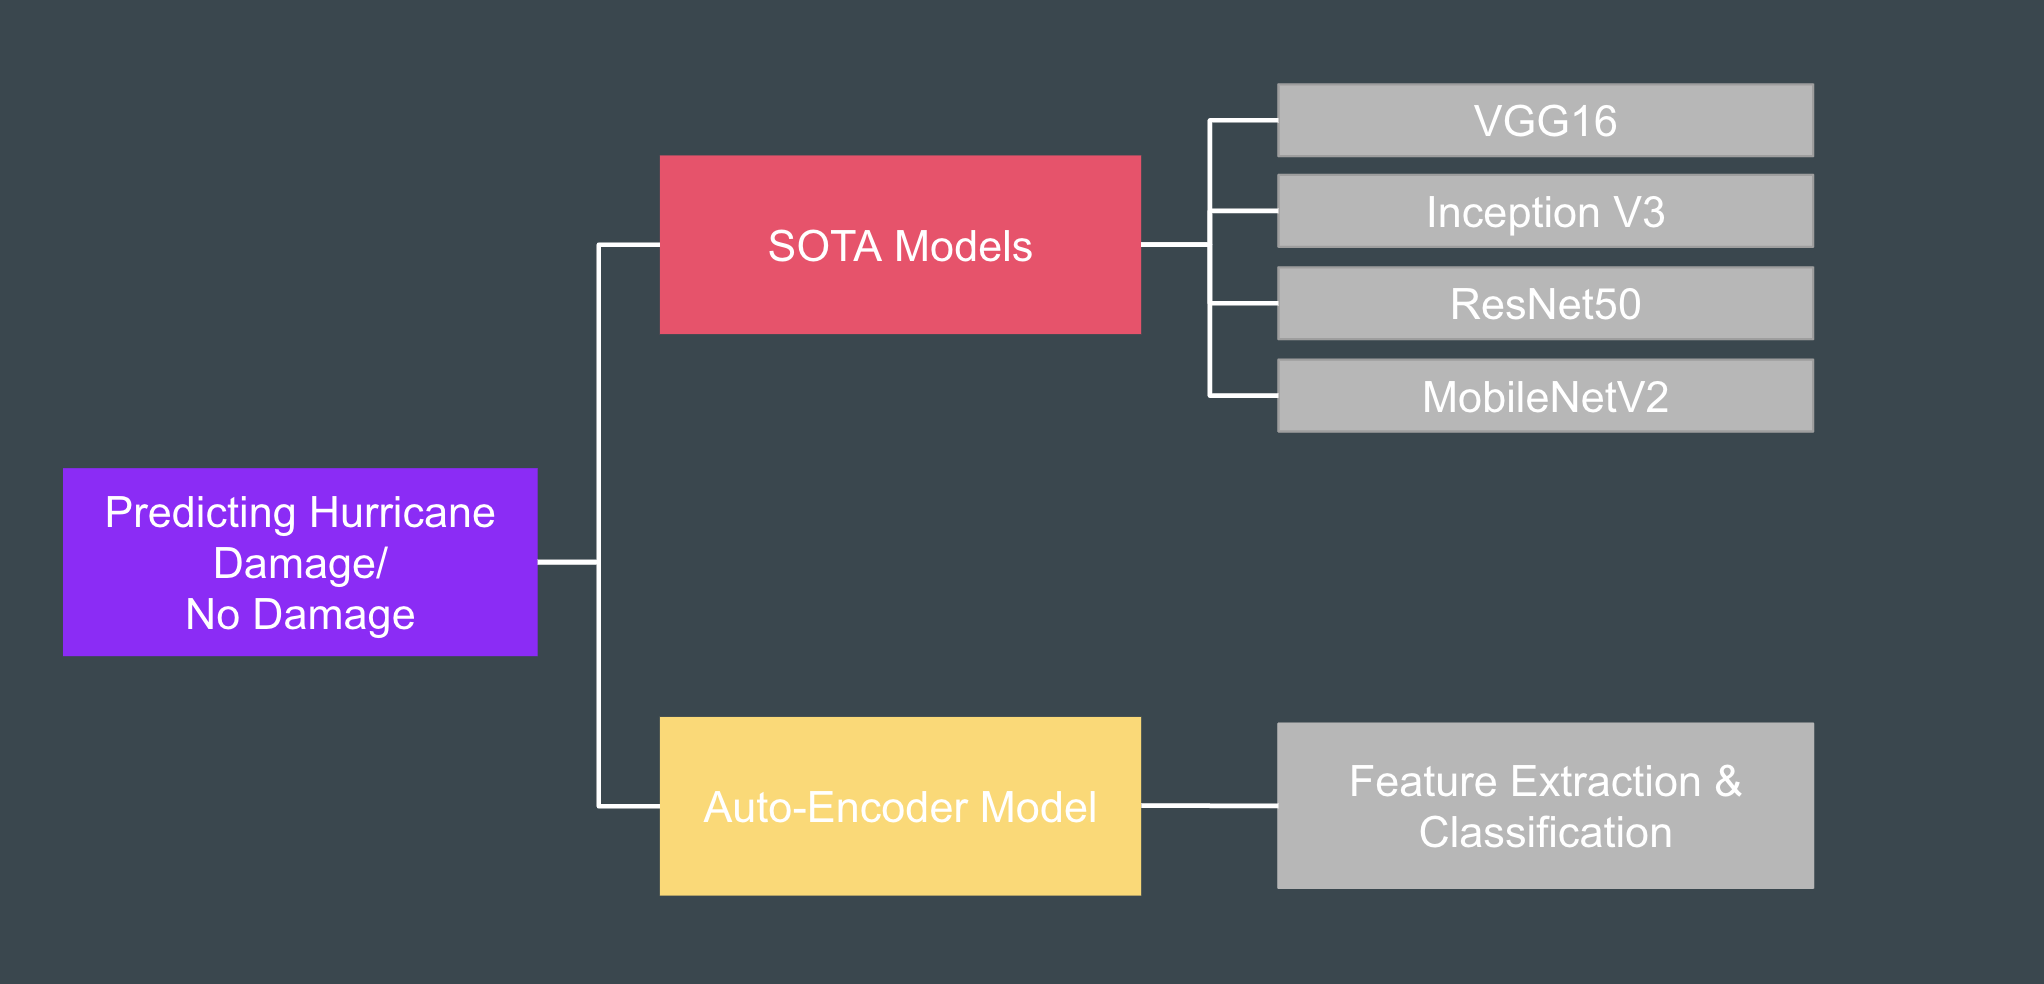

## Modelling - SOTA


VGG16: 16 layer model that stacks convolutions and finishes with a dense layer. 

Inception V3: Uses multiple kernel sizes on the same layer making the architecture wider, then deeper. 

ResNet50: Used to build deeper models using skip connections to simultaneously find a optimised number of layers to negate the vanishing gradient problem.

MobileNetV2: Uses depth wise separable convolutions which significantly reduces the number of parameters. 

The test_another dataset has an 8:1 class imbalance in favour of damaged buildings. This can result in a bias in classification towards the majority class. We introduce class weights to avoid this and improve the model performance.  This was done on ResNet50 Model. 


## Modelling - Auto Encoders

An autoencoder model was used to encode and decode the image to produce the code of the image. The idea is to see if the code of the image is able to capture key difference in the two classes. This code is then fed to a FNN as features to learn from to classify 

## Methodology

Dataset - A collection of satellite images consisting of both damaged and non-damaged buildings post-hurricane served as the dataset. It was divided into four sub-folders for training, validation and, testing. Testing will be done on two datasets - one with balanced classes and the other with imbalanced classes

train_another: the training data; 5000 images of each class(damage/no damage)

validation_another: the validation data; 1000 images of each class(damage/no damage)

test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

test: the balanced test data; 1000 images of each class(damage/no damage)

## Libraries Used 


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm

import seaborn as sns

import os
import json
from tqdm import tqdm

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Lambda


In [ ]:
# importing the required libraries
!pip -qq install tf_keras_vis 
%matplotlib inline
plt.style.use('ggplot')

import warnings
import glob
import pickle
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from PIL import Image
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from tensorflow.keras import optimizers
from sklearn import metrics



from scipy.signal import convolve2d
%matplotlib inline
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import certifi
import urllib3  
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds


In [ ]:
!pip install google.colab

     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 112kB 17.8MB/s 
     |████████████████████████████████| 8.0MB 16.0MB/s 
     |████████████████████████████████| 10.1MB 27.7MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 491kB 48.2MB/s 
     |████████████████████████████████| 61kB 5.9MB/s 
  Created wheel for google.colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102290 sha256=48bea3010c8f3bfc4023161187711466801eba7453ee0465518dd247743a92d1
  Stored in directory: /root/.cache/pip/wheels/38/0d/59/701e300a337b2a2e07b27fe74dbfff0bc56ac58f711566ee67
  Created wheel for portpicker: filename=portpicker-1.2.0-cp36-none-any.whl size=13369 sha256=4249a1168112b44cdf3e8a885fddfcc6b62f698faaff62d1e29a338d746e3b67
  Stored in directory: /root/.cache/pip/wheels/4a/45/47/1e126be9d4605e71f00d6e6fb151611f2f4cb9770b050c7d2d
  Created wheel for

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Datasets

In [ ]:
train_another = '/content/gdrive/MyDrive/Post-hurricane.zip (Unzipped Files)/train_another'
validation_another = '/content/gdrive/MyDrive/Post-hurricane.zip (Unzipped Files)/validation_another'
test = '/content/gdrive/MyDrive/Post-hurricane.zip (Unzipped Files)/test'
test_another = '/content/gdrive/MyDrive/Post-hurricane.zip (Unzipped Files)/test_another'

In [ ]:
train_another = '/content/gdrive/MyDrive/train_another'
validation_another = '/content/gdrive/MyDrive/validation_another'
test = '/content/gdrive/MyDrive/test'
test_another = '/content/gdrive/MyDrive/test_another'

In [ ]:
datagen_en = ImageDataGenerator(rescale=1./255)

train_generator_ae = datagen_en.flow_from_directory(train_another,shuffle = True , batch_size = 64, class_mode='input', classes= ['no_damage', 'damage']) #Autoencoder data

validation_generator_ae = datagen_en.flow_from_directory(validation_another, shuffle = True , batch_size = 64, class_mode='input', classes= ['no_damage', 'damage']) #autoencoder data

train_generator_en = datagen_en.flow_from_directory(train_another,shuffle = True , batch_size = 64, class_mode= 'binary', classes= ['no_damage', 'damage']) # Encoder train

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [ ]:
#Converting Datasets to Generators

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = datagen.flow_from_directory(train_another,shuffle = True , batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 10000 images belonging to 2 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(validation_another, shuffle = True , batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator1 = datagen.flow_from_directory(test, shuffle = True , batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator2 = datagen.flow_from_directory(test_another, shuffle = True , batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 9000 images belonging to 2 classes.


### Printing Sample Image 

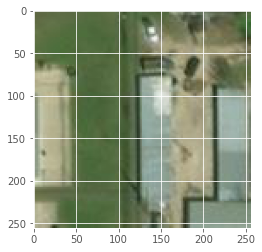

In [ ]:
plt.imshow(train_generator_en.next()[0][6])

## SOTA Models


### VGG 16 Model


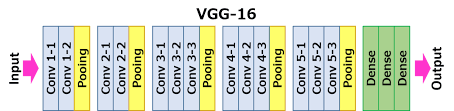

In [ ]:
vgg = VGG16(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',   input_shape=(256, 256, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
vgg.load_weights('/content/gdrive/MyDrive/Weights/vgg_weights_p2.h5') #loading the weights

In [ ]:
vgg.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
#history = vgg.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5,verbose=1)

In [ ]:
#with open('vgg_orientation.json', 'w') as file:
  #json.dump(history.history, file)

In [ ]:
#vgg.save_weights('vgg_weights_p2.h5')

#### Evaluating VGG Model

In [ ]:
with open('/content/gdrive/MyDrive/Weights/vgg_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'VGG Model accuracy and loss')

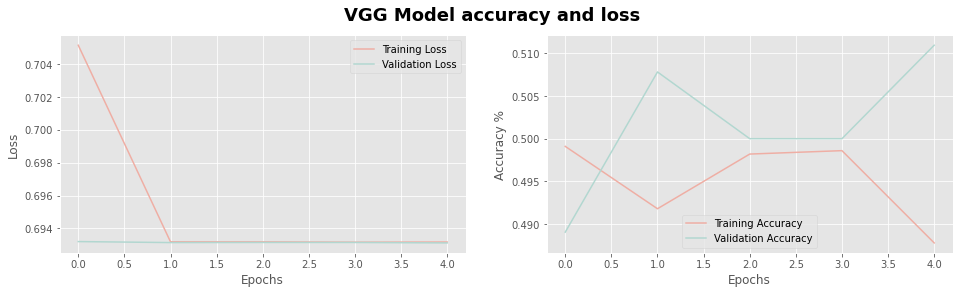

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('VGG Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference:** The model does not seem to have captured the features of damaged and no damaged class and the accuracy is no better than a random guess

In [ ]:
vgg_eval_train = vgg.evaluate(train_generator)
vgg_eval_train

157/157 [==============================] - 2634s 17s/step - loss: 0.6931 - accuracy: 0.5000


[0.6931478977203369, 0.5]

In [ ]:
vgg_eval_val = vgg.evaluate(validation_generator)
vgg_eval_val

32/32 [==============================] - 519s 16s/step - loss: 0.6931 - accuracy: 0.5000


[0.6931480169296265, 0.5]

In [ ]:
vgg_eval_test1 = vgg.evaluate(test_generator1)
vgg_eval_test1

32/32 [==============================] - 511s 16s/step - loss: 0.6931 - accuracy: 0.5000


[0.6931480169296265, 0.5]

In [ ]:
vgg_eval_test2 = vgg.evaluate(test_generator2)
vgg_eval_test2

141/141 [==============================] - 2455s 17s/step - loss: 0.6921 - accuracy: 0.8889


[0.6921389698982239, 0.8888888955116272]

**Inference**: Three datasets the model have accuracy at 50%, which is no better than a random gues s. A higher accuracy for the unbalanced dataset (test another) can be explained due to class imbalance 

#### Saliency Maps for VGG Model

In [ ]:
# The `output` variable refer to the output of the model,
def loss(output):
    return (output[0][0])

In [ ]:
def model_modifier(m): #Change last activation layer to linear
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [ ]:
#Saliency Map
saliency_vgg = Saliency(vgg,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_vgg = Gradcam(vgg,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
vgg_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_vgg_test1 = saliency_vgg(loss,
                        np.float32(vgg_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_vgg_test1 = normalize(saliency_vgg_test1)

In [ ]:
#GradCam
gradcam_vgg_test1 = gradcam_vgg(loss, 
              np.float32(vgg_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_vgg_test1 = normalize(gradcam_vgg_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


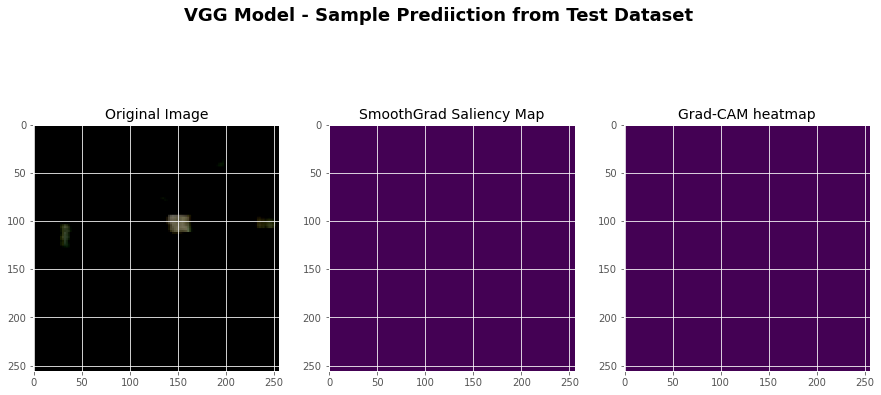

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("VGG Model - Sample Prediction from Test Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_vgg_test1[0], gradcam_vgg_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
vgg_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_vgg_test2 = saliency_vgg(loss,
                        np.float32(vgg_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_vgg_test2 = normalize(saliency_vgg_test2)

In [ ]:
#GradCam
gradcam_vgg_test2 = gradcam_vgg(loss, 
              np.float32(vgg_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_vgg_test2 = normalize(gradcam_vgg_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


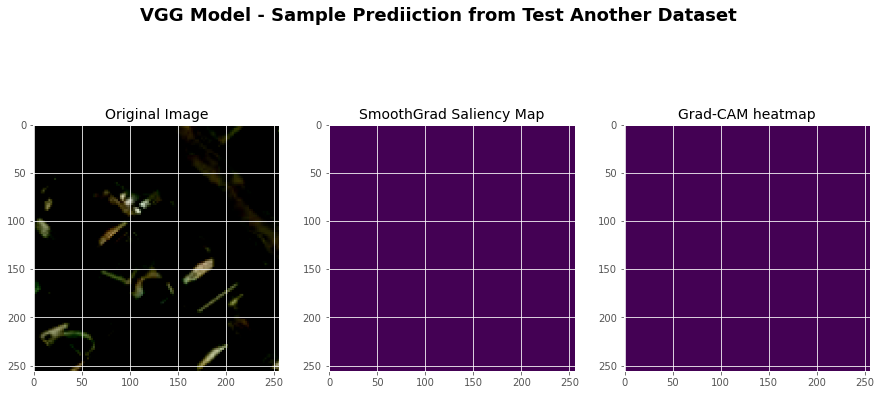

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("VGG Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator2.next()[0][6], saliency_vgg_test2[0], gradcam_vgg_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

**Inference**:  Looking at the saliency of the observation, it is clear that the model has failed to capture essential details of the image that is essential for classification and is hence performing poorly.

### Inception V3 Model

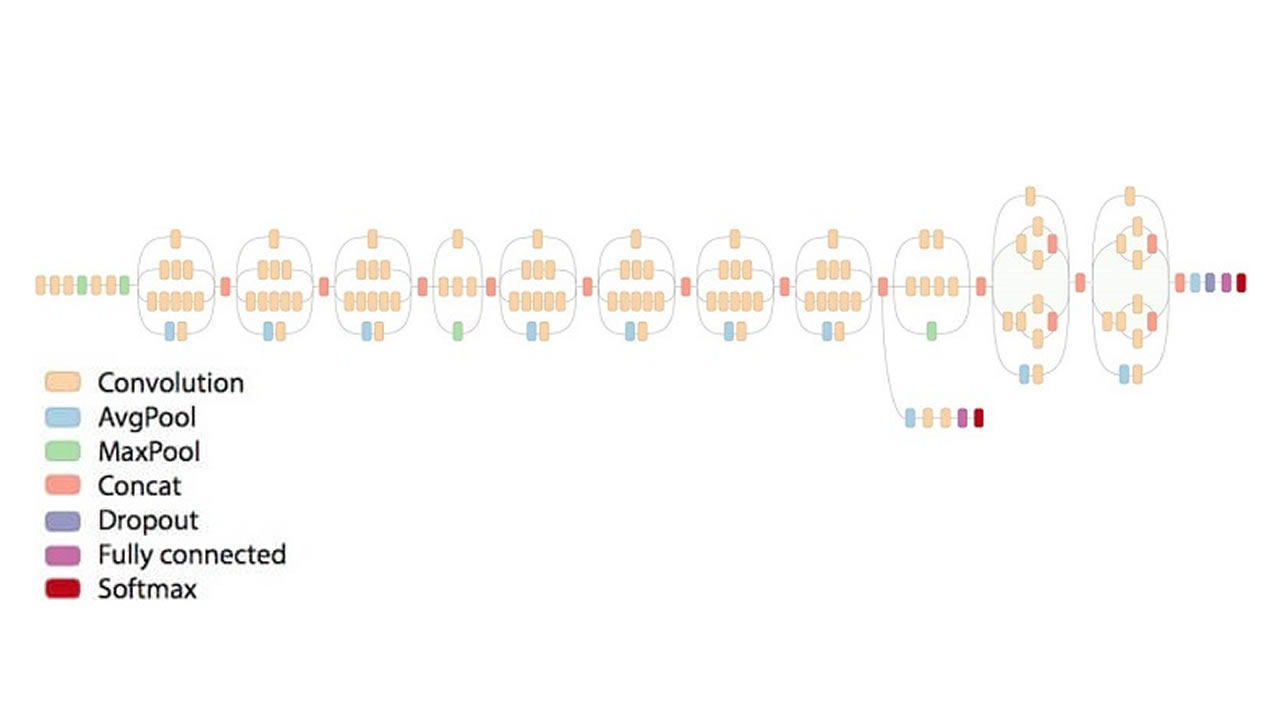

In [ ]:
inception_model = InceptionV3(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',  input_shape=(256, 256, 3))

inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
inception_model.load_weights('/content/gdrive/MyDrive/Weights/inception_model_weights_p2.h5') #loading the weights

In [ ]:
inception_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
#history = inception_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5, verbose=1)

In [ ]:
#import json
#with open('inception_orientation.json', 'w') as file:
  #json.dump(history.history, file)

In [ ]:
#inception_model.save_weights('inception_model_weights_p2.h5')

#### Evaluating Inception Model

In [ ]:
with open('/content/gdrive/MyDrive/Weights/inception_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'Inception V3 Model accuracy and loss')

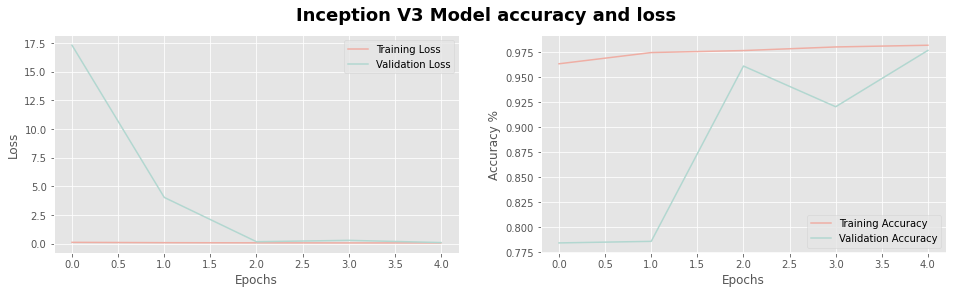

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Inception V3 Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference**: In just 2 epochs, the loss is very close to zero and the accuracy on the validation reaches a good 96%. Let's look at the model's performance on test and test another datasets


In [ ]:
inception_eval_train = inception_model.evaluate(train_generator)
inception_eval_train

157/157 [==============================] - 29s 185ms/step - loss: 0.0676 - accuracy: 0.9774


[0.06756407022476196, 0.977400004863739]

In [ ]:
inception_eval_val = inception_model.evaluate(validation_generator)
inception_eval_val

32/32 [==============================] - 6s 179ms/step - loss: 0.0747 - accuracy: 0.9775


[0.07467493414878845, 0.9775000214576721]

In [ ]:
inception_eval_test1= inception_model.evaluate(test_generator1)
inception_eval_test1

32/32 [==============================] - 6s 180ms/step - loss: 0.0903 - accuracy: 0.9740


[0.09029728919267654, 0.9739999771118164]

In [ ]:
inception_eval_test2 = inception_model.evaluate(test_generator2)
inception_eval_test2

141/141 [==============================] - 27s 188ms/step - loss: 0.1228 - accuracy: 0.9619


[0.12280594557523727, 0.9618889093399048]

**Inference**: The model generalises well on both the test datasets. Test dataset has an accuracy of 0.97 and the test_another dataset has an accuracy of 0.96

#### Saliency Maps for Inception Model

In [ ]:
#Saliency Map
saliency_inception = Saliency(inception_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_inception = Gradcam(inception_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
inception_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_inception_test1 = saliency_inception(loss,
                        np.float32(inception_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_inception_test1 = normalize(saliency_inception_test1)

In [ ]:
#GradCam
gradcam_inception_test1 = gradcam_inception(loss, 
              np.float32(inception_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_inception_test1 = normalize(gradcam_inception_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


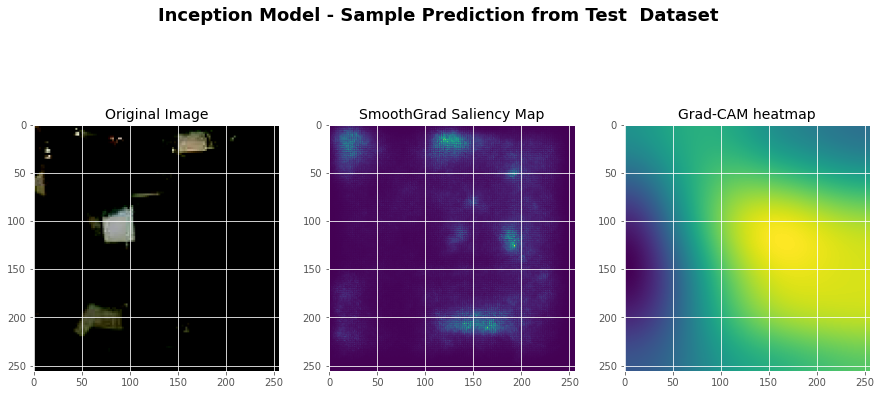

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Inception Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_inception_test1[0], gradcam_inception_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
inception_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_inception_test2 = saliency_inception(loss,
                        np.float32(inception_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_inception_test2 = normalize(saliency_inception_test2)

In [ ]:
#GradCam
gradcam_inception_test2 = gradcam_inception(loss, 
              np.float32(inception_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_inception_test2 = normalize(gradcam_inception_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


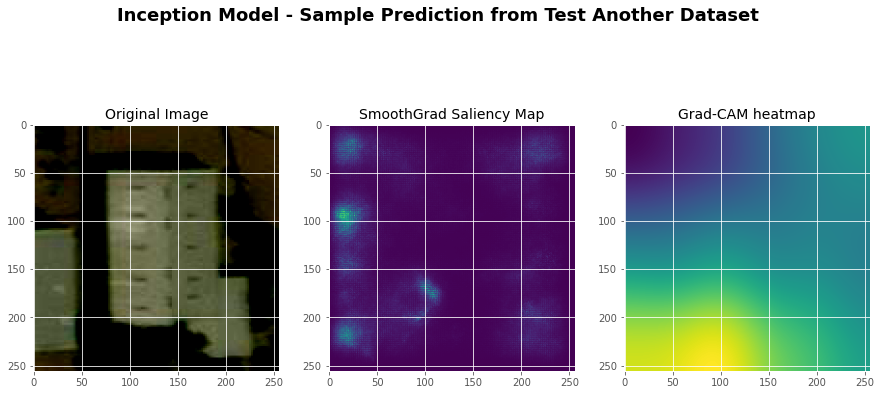

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Inception Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_inception_test2[0], gradcam_inception_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

**Inference**: Looking at the saliency it is clear that the inception model is picking up on crucial details and it seems like the model is paying attention to the buildings. 

### ResNet50 Model


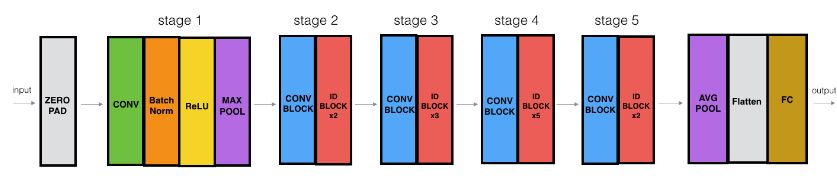

In [ ]:
resnet_model = ResNet50(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',  input_shape=(256, 256, 3))
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
resnet_model.load_weights('/content/gdrive/MyDrive/Weights/resnet_model_weights_p2.h5') #loading the weights

In [ ]:
resnet_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
#history = resnet_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5,verbose=1)

In [ ]:
#import json 
#with open('history_orientation.json', 'w') as file:
  #json.dump(history.history, file)

In [ ]:
#resnet_model.save_weights('resnet_model_weights_p2.h5')

#### Evaluating ResNet Model

In [ ]:
with open('/content/gdrive/MyDrive/Weights/resnet_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'ResNet50 Model accuracy and loss')

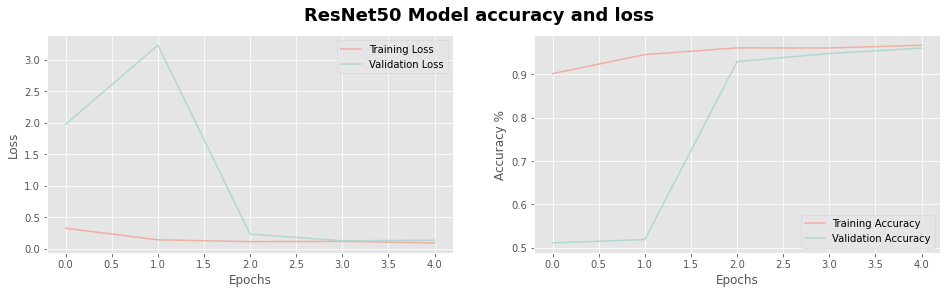

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('ResNet50 Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference**: ResNet also performs really well with an accuracy of over 90% on validation data Let's check it's performance on test datasets 

In [ ]:
resnet_eval_train = resnet_model.evaluate(train_generator)
resnet_eval_train

157/157 [==============================] - 42s 269ms/step - loss: 0.1116 - accuracy: 0.9655


[0.11155878007411957, 0.965499997138977]

In [ ]:
resnet_eval_val = resnet_model.evaluate(validation_generator)
resnet_eval_val

32/32 [==============================] - 8s 257ms/step - loss: 0.1189 - accuracy: 0.9665


[0.11893142759799957, 0.9664999842643738]

In [ ]:
resnet_eval_test1 = resnet_model.evaluate(test_generator1)
resnet_eval_test1

32/32 [==============================] - 8s 254ms/step - loss: 0.1131 - accuracy: 0.9655


[0.11313345283269882, 0.965499997138977]

In [ ]:
resnet_eval_test2 = resnet_model.evaluate(test_generator2)
resnet_eval_test2

141/141 [==============================] - 38s 267ms/step - loss: 0.1101 - accuracy: 0.9752


[0.11007274687290192, 0.9752222299575806]

**Inference**: The model generalises well on both the test datasets. Test dataset has an accuracy of 0.97 and the test_another dataset has an accuracy of 0.98

#### Saliency Maps for ResNet Model

In [ ]:
#Saliency Map
saliency_resnet = Saliency(resnet_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_resnet = Gradcam(resnet_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
resnet_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_resnet_test1 = saliency_resnet(loss,
                        np.float32(resnet_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_resnet_test1 = normalize(saliency_resnet_test1)

In [ ]:
#GradCam
gradcam_resnet_test1 = gradcam_resnet(loss, 
              np.float32(resnet_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_resnet_test1 = normalize(gradcam_resnet_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


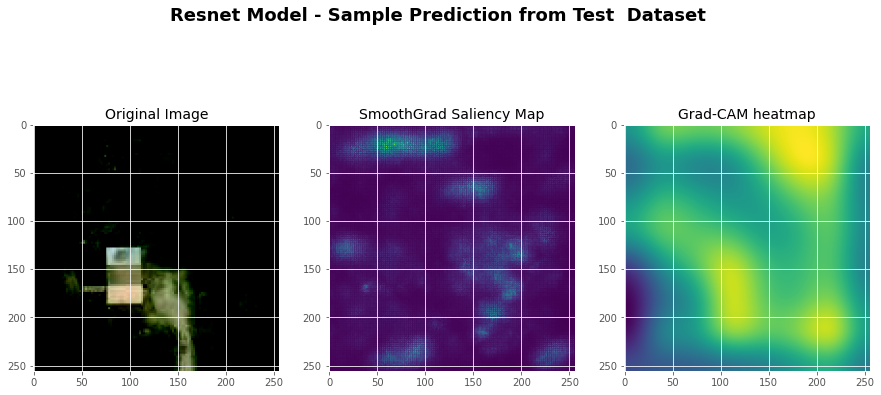

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Resnet Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_resnet_test1[0], gradcam_resnet_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
resnet_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_resnet_test2 = saliency_resnet(loss,
                        np.float32(resnet_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_resnet_test2 = normalize(saliency_resnet_test2)

In [ ]:
#GradCam
gradcam_resnet_test2 = gradcam_resnet(loss, 
              np.float32(resnet_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_resnet_test2 = normalize(gradcam_resnet_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


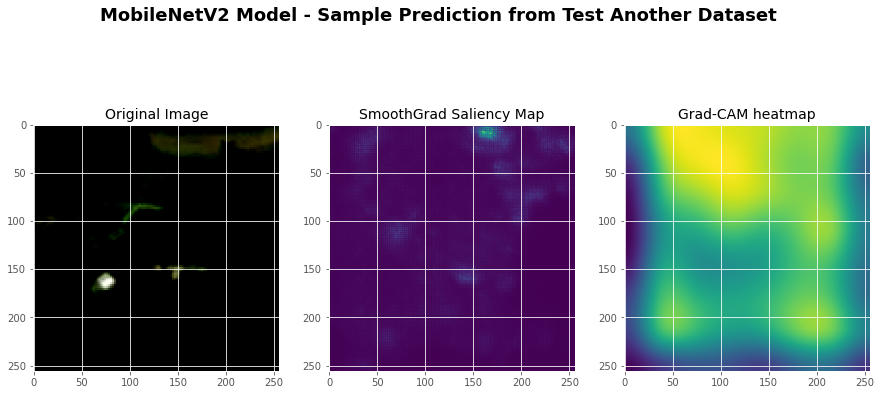

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("MobileNetV2 Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_resnet_test2[0], gradcam_resnet_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

### MobileNetV2 *Model*

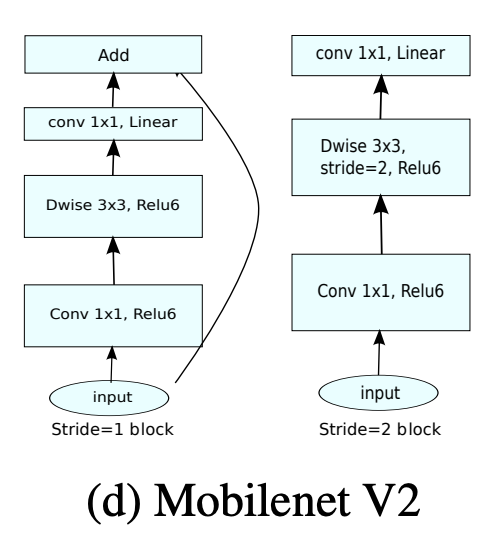

In [ ]:
mobilenetv2_model = MobileNetV2( weights=None, classes=1, classifier_activation='sigmoid', input_shape=(256, 256, 3))
mobilenetv2_model.summary()

Model: "mobilenetv2_1.00_256"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
mobilenetv2_model.load_weights('/content/gdrive/MyDrive/Weights/mobilenetv2_weights_p2.h5') #loading the weights

In [ ]:
mobilenetv2_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
#history = mobilenetv2_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=4,verbose=1)

In [ ]:
#with open('mobilenet_orientation.json', 'w') as file:
  #json.dump(history.history, file)

In [ ]:
#mobilenetv2_model.save_weights('mobilenetv2_weights_p2.h5')

#### Evaluating MobileNet Model

In [ ]:
with open('/content/gdrive/MyDrive/Weights/mobilenet_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'MobileNet Model accuracy and loss')

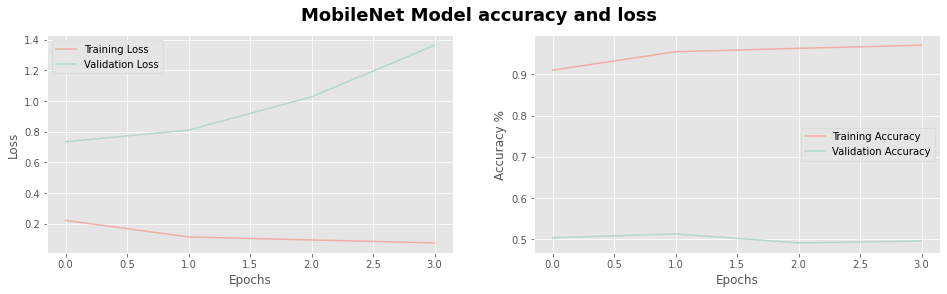

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MobileNet Model accuracy and loss', fontsize = 18, fontweight= 'bold')

In [ ]:
mobilenet_eval_train = mobilenetv2_model.evaluate(train_generator)
mobilenet_eval_train

157/157 [==============================] - 26s 163ms/step - loss: 1.3522 - accuracy: 0.5000


[1.352218508720398, 0.5]

In [ ]:
mobilenet_eval_val = mobilenetv2_model.evaluate(validation_generator)
mobilenet_eval_val

32/32 [==============================] - 5s 154ms/step - loss: 1.3522 - accuracy: 0.5000


[1.3522183895111084, 0.5]

In [ ]:
mobilenet_eval_test1 = mobilenetv2_model.evaluate(test_generator1)
mobilenet_eval_test1

32/32 [==============================] - 5s 158ms/step - loss: 1.3522 - accuracy: 0.5000


[1.3522183895111084, 0.5]

In [ ]:
mobilenet_eval_test2 = mobilenetv2_model.evaluate(test_generator2)
mobilenet_eval_test2

141/141 [==============================] - 23s 164ms/step - loss: 0.3587 - accuracy: 0.8889


[0.35870134830474854, 0.8888888955116272]

**Inference**: Three datasets the model have accuracy at 50%, which is no better than a random gues s. A higher accuracy for the unbalanced dataset (test another) can be explained due to class imbalance 

#### Saliency Maps for MobilNet Model



In [ ]:
#Saliency Map
saliency_mobilenet = Saliency(mobilenetv2_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_mobilenet = Gradcam(mobilenetv2_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
mobilenet_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_mobilenet_test1 = saliency_mobilenet(loss,
                        np.float32(mobilenet_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_mobilenet_test1 = normalize(saliency_mobilenet_test1)

In [ ]:
#GradCam
gradcam_mobilenet_test1 = gradcam_mobilenet(loss, 
              np.float32(mobilenet_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_mobilenet_test1 = normalize(gradcam_mobilenet_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


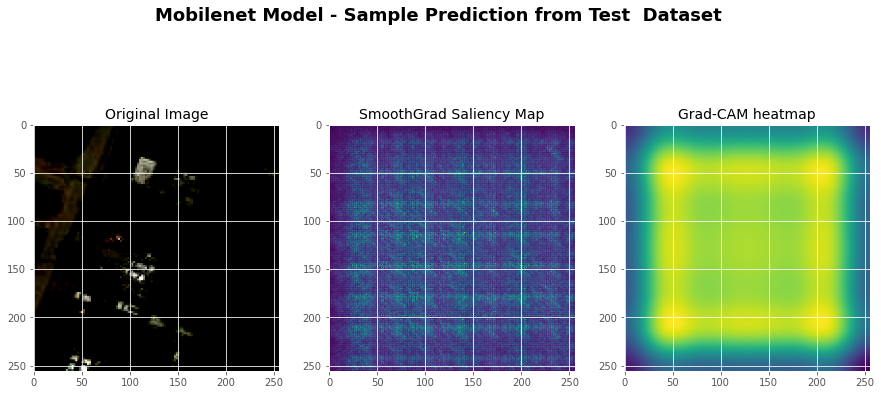

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Mobilenet Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_mobilenet_test1[0], gradcam_mobilenet_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
mobilenet_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_mobilenet_test2 = saliency_mobilenet(loss,
                        np.float32(mobilenet_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_mobilenet_test2 = normalize(saliency_mobilenet_test2)

In [ ]:
#GradCam
gradcam_mobilenet_test2 = gradcam_mobilenet(loss, 
              np.float32(mobilenet_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_mobilenet_test2 = normalize(gradcam_mobilenet_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


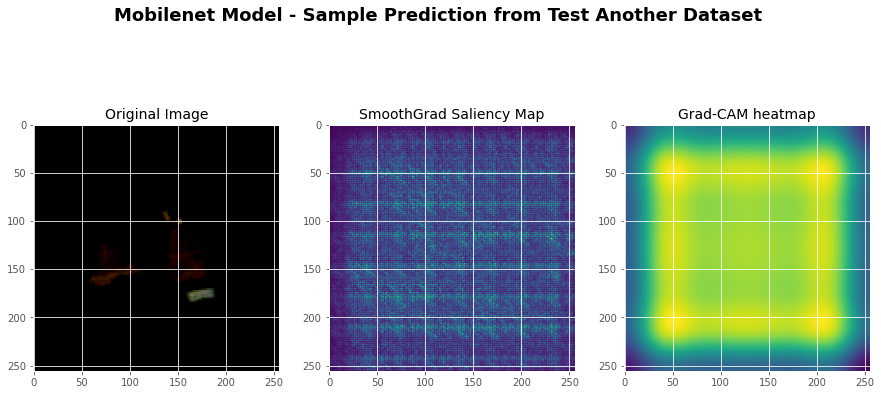

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Mobilenet Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator2.next()[0][6], saliency_mobilenet_test2[0], gradcam_mobilenet_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

**Inference**: It looks like the model is not able to focus specific features and is hence therefore not performing well 

## Auto Encoder Model: Classification using encoded features 

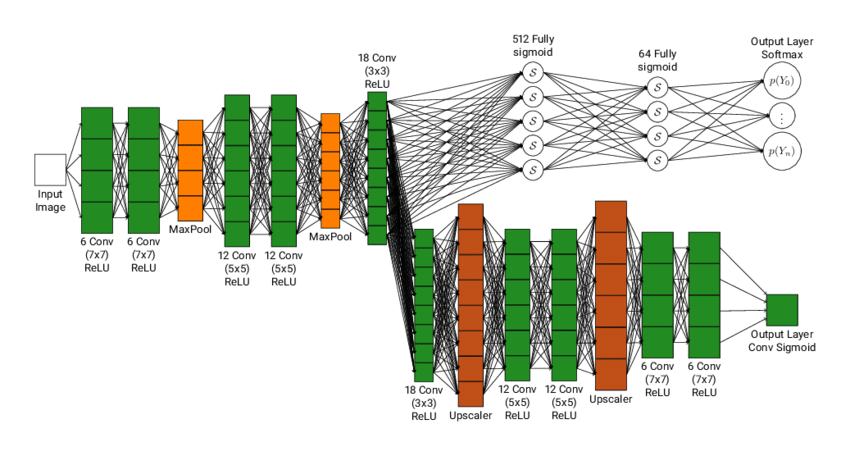

An autoencoder is a neural network model that seeks to learn a compressed representation of an input. The design of the autoencoder model purposefully makes this challenging by restricting the architecture to a bottleneck at the midpoint of the model, from which the reconstruction of the input data is performed. We will then use the bottle neck latent features as inputs for a classification model and see how well it performs. The idea is to build a autoencoder, then discard the decoder. We can now use the encoder to encode the models and use it as features to learn from. 

### Building the Encoder

In [ ]:
cae = Sequential() 
pool_size=(2,2)
# ENCODER 
# Convolutional layer by specifying the number of filters as 32,
# kernel size 3 
cae.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same',input_shape = (256, 256, 3)))
cae.add(LeakyReLU(alpha=0.1))

# Maxpool layer with 'same' padding and defined pool_size
cae.add(MaxPooling2D(padding = 'same', pool_size = pool_size))
cae.add(LeakyReLU(alpha=0.1))

cae.add(Conv2D(filters = 3, kernel_size = (3,3), padding = 'same'))
cae.add(LeakyReLU(alpha=0.1))

# Maxpool layer with 'same' padding and defined pool_size
cae.add(MaxPooling2D(padding = 'same', pool_size = pool_size))
cae.add(LeakyReLU(alpha=0.1))

# DECODER 
# Convolutional layer by specifying the number of filters as 32,
cae.add(Conv2D(filters = 32, kernel_size = (1,1)))

# upsampling layer with defined pool_size
cae.add(UpSampling2D(size = pool_size))

# Convolutional layer by specifying the number of filters as 3
cae.add(Conv2D(filters = 3, kernel_size = (1,1), activation = 'linear'))

cae.add(UpSampling2D(size = pool_size))
# Compile the model with mse as the loss and Adam optimizer with 0.003 as the parameter
cae.compile(optimizer = 'Adam', loss = 'mse')
 
# Get the model summary
cae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 3)       867       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 3)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 3)        

In [ ]:
cae.load_weights('/content/autoencoder_model_64.h5')

In [ ]:
inspect = train_generator_en.next()

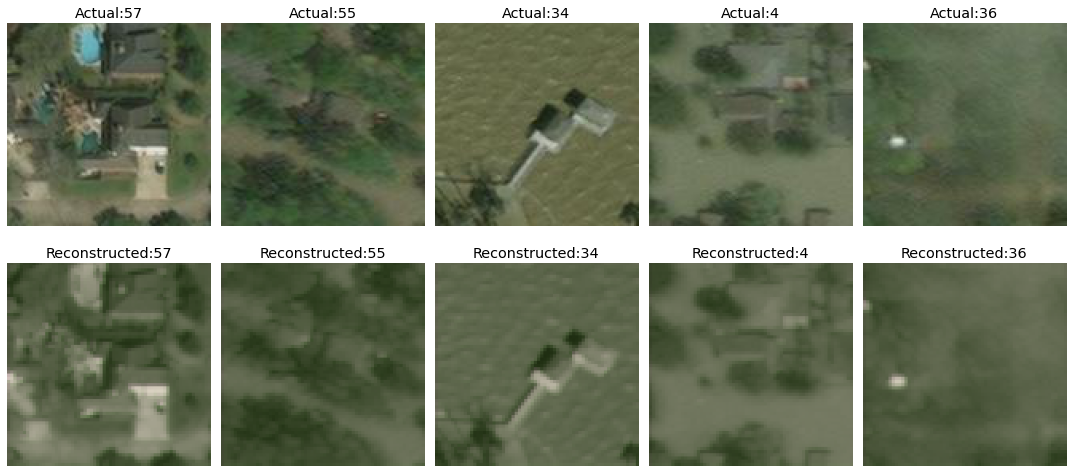

In [ ]:
fig, ax = plt.subplots(2,5, figsize=(15,7))

for i in (range(5)):
    chosen = np.random.choice(64)
    ax[0,i].imshow(inspect[0][chosen])
    ax[1,i].imshow(cae.predict(inspect[0][chosen].reshape(-1, 256, 256, 3)).reshape(256, 256, 3))
    ax[0,i].set_title(f'Actual:{chosen}') 
    ax[1,i].set_title(f'Reconstructed:{chosen}') 
    ax[0,i].axis('off')
    ax[1,i].axis('off')
plt.tight_layout()

In [ ]:
import json
with open('/content/History_cae.json') as file:
  data = json.load(file)

Text(0.5, 0.98, 'Autoencoder Model loss')

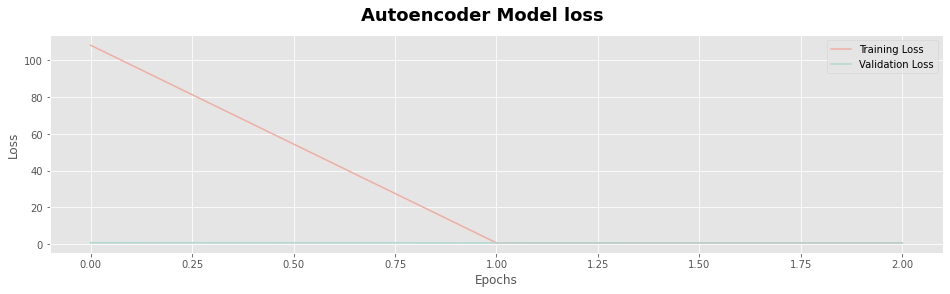

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,4))
plt.plot(data_en['loss'],color='#EFAEA4',label = 'Training Loss')
plt.plot(data_en['val_loss'],color='#B2D7D0',label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
fig.suptitle('Autoencoder Model loss', fontsize = 18, fontweight= 'bold')

**Inference**: With a loss less than 0.1, the autoencoder has really learnt to compress the image and retain it's features

In [ ]:
# Selecting the encoding layers. This is our final encoder
latent_model = Sequential()
latent_model.add(cae.layers[0])
latent_model.add(cae.layers[1])
latent_model.add(cae.layers[2])
latent_model.add(cae.layers[3])
latent_model.add(cae.layers[4])
latent_model.add(cae.layers[5])
latent_model.add(cae.layers[6])
latent_model.add(cae.layers[7])

In [ ]:
#Classifier model
regularizer_value = tf.keras.regularizers.l2(l2=0.1) #regularizer

input_img = Input(shape=(256, 256, 3))

d1 = Lambda(lambda x: latent_model(x))(input_img)  #lambda layer for applying encoding in the input images

d2 = Flatten()(d1) #Flatten

d3 = Dense(12288, kernel_regularizer=regularizer_value,activation = 'relu')(d2) # Dense layer 1

d4 = Dropout(0.2)(d3) #Dropout layer

d5 = Dense(6144, kernel_regularizer=regularizer_value,  activation = 'relu')(d4) #Dense layer 2

d6 = Dense(3072,kernel_regularizer=regularizer_value,  activation = 'relu')(d5) # Dense layer 3

d7 = Dense(1024, kernel_regularizer=regularizer_value, activation = 'relu')(d6) #Dense layer 4

d8 = Dense(64, kernel_regularizer=regularizer_value, activation = 'relu')(d7)# Dense layer 5

pred = Dense(1, activation = 'sigmoid')(d8) #output

classifier = Model(input_img, pred) #classifier

In [ ]:
classifier.compile(Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss')]

In [ ]:
import json
with open('/content/autoencoder_en_64.json') as file:
  data_en = json.load(file)

Text(0.5, 0.98, 'Classifier Model accuracy and loss')

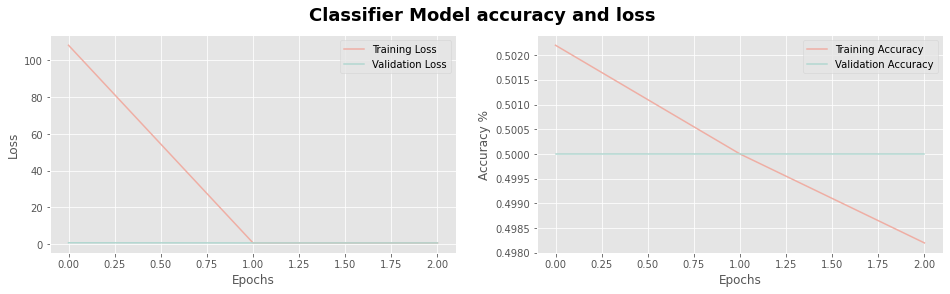

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(data_en['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(data_en['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(data_en['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(data_en['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Classifier Model accuracy and loss', fontsize = 18, fontweight= 'bold')

Inference: The FNN model does not perform well with an accurasy of 50% on validation set which is no better than random guess

# Conclusion

Of the various models we tried, It looks like inceptionV3 and ResNet models performed the best with accuarcies over 90% on both train, validation and test datasets. These models were able to perform inspite of the class imbalance in test another dataset. One of the reasons why inception model worked so well is that the architecture uses tricks to boost performance. Inception model uses multiple kernel sizes in the same layer which makes the network wider than deeper. The model is now capable of picking important features necessary to make the classification. On the other hand, The principle on which ResNets work is to build a deeper networks compared to other plain networks and simultaneously find a optimised number of layers to negate the vanishing gradient problem.

Improvements: Exploring more SOTA models and using more advanced models for classification. Preprocessing the the images manually to help sota models capture features more easily.